In [1]:
import numpy as np
import pandas as pd
from deal_analyzer import generate_deal_specs, DealAnalyzer

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
deal_specs = generate_deal_specs()
deal_specs

{'purchase_price': 895000,
 'land_value': 50000,
 'depreciable_life': 27.5,
 'building_sf': 8800,
 'rentable_sf': 6525,
 'improvement_cost_per_sf': 62,
 'closing_costs': 50000,
 'debt_share': 0.75,
 'interest_rate': 0.0425,
 'term': 5,
 'amortization_period': 25,
 'number_of_units': 27,
 'monthly_school_rent': 650,
 'daily_summer_rent': 100,
 'school_year_occupancy_rate': 0.95,
 'summer_occupancy_rate': 0.5,
 'operating_expenses_per_sf': 10,
 'capital_reserves_per_unit': 357.14,
 'annual_growth': 0.03,
 'real_estate_tax_rate': 0.12,
 'income_tax_rate': 0.396,
 'sell_cap_rate': 0.1,
 'years_held': 5,
 'investor_contribution': 0.9,
 'investor_preferred_return': 0.08,
 'investor_profit_share': 0.5}

In [3]:
analyzer = DealAnalyzer(**deal_specs)
analyzer.investor_waterfall

{'net_operating_income': array([125795.72      , 129569.5916    , 133456.679348  , 137460.37972844,
        141584.19112029]),
 'cash_flow_after_financing': array([59996.48112395, 63770.35272395, 67657.44047195, 71661.14085239,
        75784.95224425]),
 'net_cash_flows': array([-337387.5       ,   59996.48112395,   63770.35272395,
          67657.44047195,   71661.14085239,  554110.45765979]),
 'deal_irr': 0.24702690038541286,
 'investor': {'contribution': 303648.75,
  'preferred_return': 24291.9,
  'cash_flows': array([-303648.75      ,   40794.64056198,   42681.57636198,
           44625.12023598,   46626.9704262 ,  422806.6288299 ]),
  'irr': 0.17764711899000596},
 'sponsor': {'contribution': 33738.74999999999,
  'preferred_return': 2699.0999999999995,
  'cash_flows': array([-33738.75      ,  19201.84056198,  21088.77636198,  23032.32023598,
          25034.1704262 , 131303.8288299 ]),
  'irr': 0.7323214494176093}}

In [24]:
def sensitivity_analysis_trial(opccupancy_rate_triangular=False):
    # copy the deal specs
    deal_specs_rv = deal_specs.copy()
    # sample random values
    # riskiest inputs are occupancy and rent
    if opccupancy_rate_triangular:
        deal_specs_rv['school_year_occupancy_rate'] = (
            np.random.triangular(left=0.86, mode=0.95, right=0.97)
        )
        deal_specs_rv['summer_occupancy_rate'] = (
            np.random.triangular(left=0.40, mode=0.50, right=0.55)
        )
    else:
        deal_specs_rv['school_year_occupancy_rate'] = (
            np.random.uniform(low=0.86, high=0.97)
        )
        deal_specs_rv['summer_occupancy_rate'] = (
            np.random.uniform(low=0.40, high=0.55)
        )
    deal_specs_rv['monthly_school_rent'] = (
        np.random.triangular(left=625, mode=650, right=700)
    )
    deal_specs_rv['daily_summer_rent'] = (
        np.random.triangular(left=85, mode=100, right=115)
    )
    # run analyzer
    analyzer_rv = DealAnalyzer(**deal_specs_rv)
    investor_waterfall = analyzer_rv.investor_waterfall
    cfaf_yr1 = investor_waterfall["cash_flow_after_financing"][0]
    investor_preferred_return = investor_waterfall['investor']['preferred_return']
    sponsor_preferred_return = investor_waterfall['sponsor']['preferred_return']
    return {
        # sampled values
        "school_year_occupancy_rate": deal_specs_rv['school_year_occupancy_rate'],
        "summer_occupancy_rate": deal_specs_rv['summer_occupancy_rate'],
        "monthly_school_rent": deal_specs_rv['monthly_school_rent'],
        "daily_summer_rent": deal_specs_rv['daily_summer_rent'],
        # does the deal go into the negative?
        "cfaf_yr1": cfaf_yr1,
        "cash_flow_positive": cfaf_yr1 > 0,
        # can the preferred return be made?
        "investor_preferred_return_covered": cfaf_yr1 > investor_preferred_return,
        "sponsor_preferred_return_covered": cfaf_yr1 > (
            investor_preferred_return + sponsor_preferred_return
        ),
        # investment outcomes
        "deal_irr": investor_waterfall["deal_irr"],
        "investor_irr": investor_waterfall["investor"]["irr"],
        "investor_cash_in": investor_waterfall["investor"]["contribution"],
        "investor_cash_out": investor_waterfall["investor"]["cash_flows"].sum(),
        "sponsor_irr": investor_waterfall["sponsor"]["irr"],
        "sponsor_cash_in": investor_waterfall["sponsor"]["contribution"],
        "sponsor_cash_out": investor_waterfall["sponsor"]["cash_flows"].sum(),
    }

In [22]:
sensitivity_analysis_trial(False)

{'school_year_occupancy_rate': 0.9139718287642473,
 'summer_occupancy_rate': 0.46633256217323754,
 'monthly_school_rent': 640.0705903482426,
 'daily_summer_rent': 107.21238210202485,
 'cfaf_yr1': 50278.76703902532,
 'cash_flow_positive': True,
 'investor_preferred_return_covered': True,
 'sponsor_preferred_return_covered': True,
 'deal_irr': 0.18839886092093105,
 'investor_irr': 0.14185071809126337,
 'investor_cash_in': 303648.75,
 'investor_cash_out': 224340.36323361582,
 'sponsor_irr': 0.5436863656681472,
 'sponsor_cash_in': 33738.74999999999,
 'sponsor_cash_out': 116376.36323361573}

In [25]:
k_trials = 100_000

np.random.seed(90)
results_df = pd.DataFrame([sensitivity_analysis_trial() for _ in range(k_trials)])

In [26]:
results_df.head()

,school_year_occupancy_rate,summer_occupancy_rate,monthly_school_rent,daily_summer_rent,cfaf_yr1,cash_flow_positive,investor_preferred_return_covered,sponsor_preferred_return_covered,deal_irr,investor_irr,investor_cash_in,investor_cash_out,sponsor_irr,sponsor_cash_in,sponsor_cash_out
0,0.876836,0.423653,692.623800,108.444390,43957.771663,True,True,True,0.146105,0.116959,303648.75,179103.507849,0.394926,33738.75,71139.507849
1,0.880469,0.440156,650.026926,102.353512,36307.970959,True,True,True,0.088797,0.084765,303648.75,124356.920068,0.136151,33738.75,16392.920068
2,0.887655,0.495281,660.304177,101.902865,52659.756211,True,True,True,0.203401,0.150879,303648.75,241380.157832,0.593181,33738.75,133416.157832
3,0.900455,0.438725,644.089437,100.809657,36787.175522,True,True,True,0.092631,0.086857,303648.75,127786.396953,0.158159,33738.75,19822.396953
4,0.950819,0.475518,665.770620,104.597933,61332.769380,True,True,True,0.254601,0.182365,303648.75,303449.471154,0.756056,33738.75,195485.471154


In [7]:
np.mean(results_df.investor_irr < 0.10)

0.09694

In [8]:
np.mean(results_df.investor_preferred_return_covered)

0.99868

In [80]:
np.mean(results_df.sponsor_preferred_return_covered)

0.99625

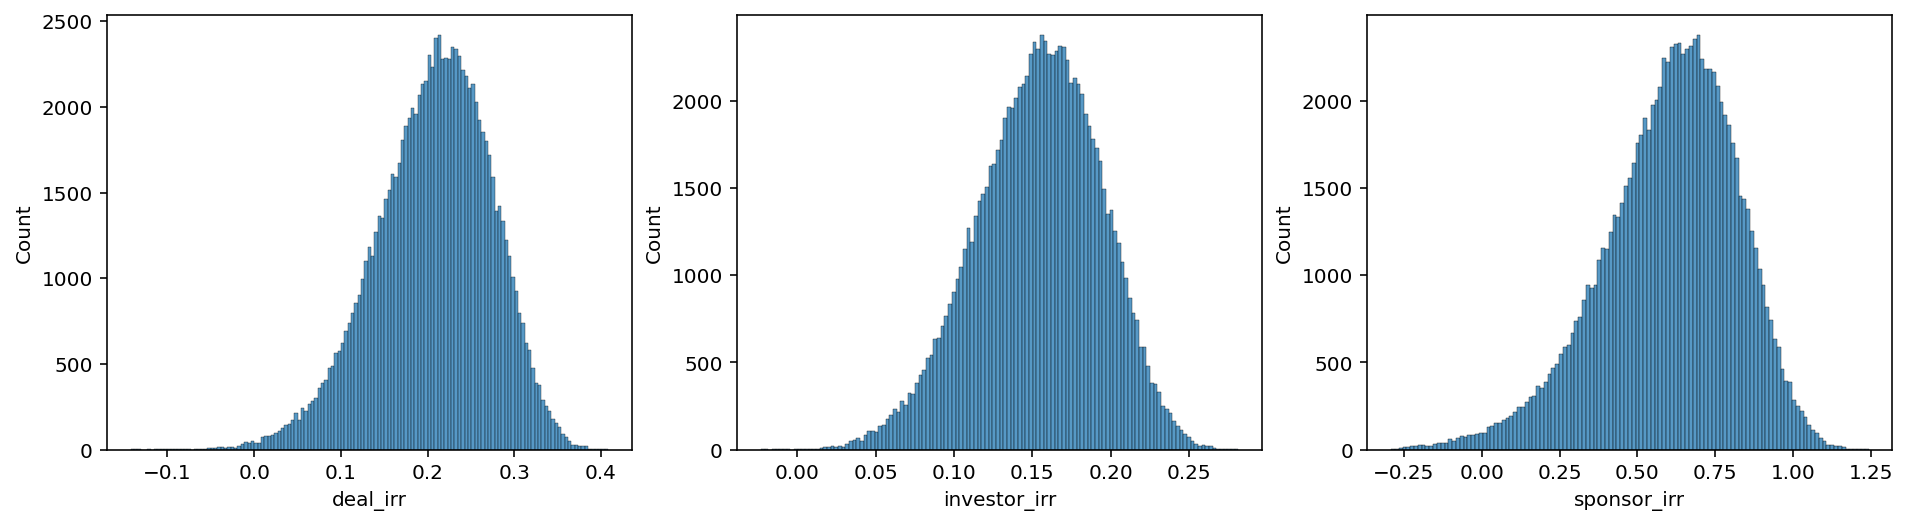

In [44]:
cols = ['deal_irr', 'investor_irr', 'sponsor_irr']

n = len(cols)
fig, ax = plt.subplots(nrows=1, ncols=n, figsize=(16, 4), sharex=False)
for i in range(n):
    plt.sca(ax[i])
    col = cols[i]
    sns.histplot(x=col, data=results_df);

In [45]:
results_long_df = pd.melt(
    results_df,
    id_vars=['school_year_occupancy_rate', 'summer_occupancy_rate', 'monthly_school_rent', 'daily_summer_rent'],
    value_vars=['deal_irr', 'investor_irr', 'sponsor_irr'],
    var_name='outcome',
    value_name='value'
)

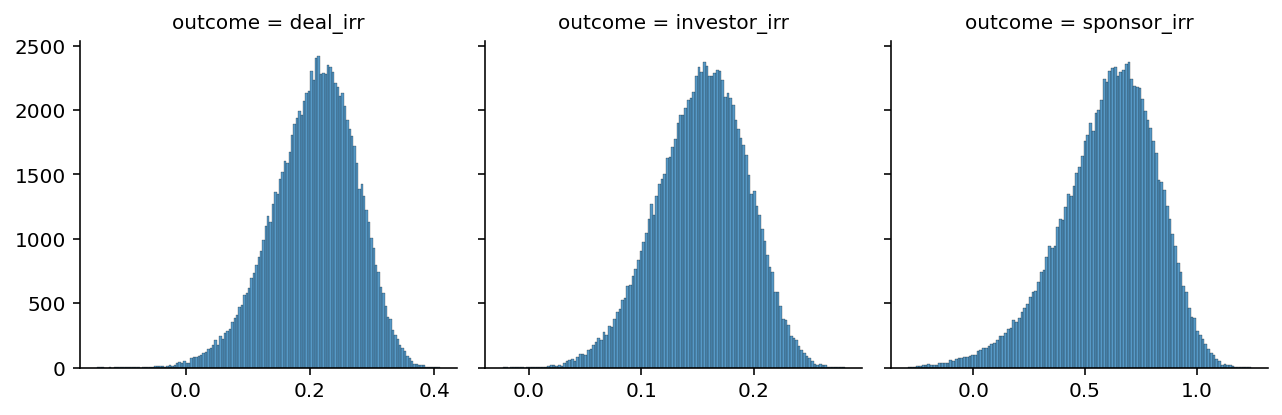

In [46]:
g = sns.FacetGrid(results_long_df, col="outcome", sharex=False)
g.map_dataframe(sns.histplot, x="value");

In [13]:
np.array(0.92750546).item()

0.92750546

In [27]:
def sensitivity_analysis_trial(opccupancy_rate_triangular=False):
    # copy the deal specs
    deal_specs_rv = deal_specs.copy()
    # sample random values
    # riskiest inputs are occupancy and rent
    deal_specs_rv['school_year_occupancy_rate'] = (
        np.where(
            opccupancy_rate_triangular,
            np.random.triangular(left=0.86, mode=0.95, right=0.97),
            np.random.uniform(low=0.86, high=0.97)
        ).item()
    )
    deal_specs_rv['summer_occupancy_rate'] = (
        np.where(
            opccupancy_rate_triangular,
            np.random.triangular(left=0.40, mode=0.50, right=0.55),
            np.random.uniform(low=0.40, high=0.55)
        ).item()
    )
    deal_specs_rv['monthly_school_rent'] = (
        np.random.triangular(left=625, mode=650, right=700)
    )
    deal_specs_rv['daily_summer_rent'] = (
        np.random.triangular(left=85, mode=100, right=115)
    )
    # run analyzer
    analyzer_rv = DealAnalyzer(**deal_specs_rv)
    investor_waterfall = analyzer_rv.investor_waterfall
    cfaf_yr1 = investor_waterfall["cash_flow_after_financing"][0]
    investor_preferred_return = investor_waterfall['investor']['preferred_return']
    sponsor_preferred_return = investor_waterfall['sponsor']['preferred_return']
    return {
        # sampled values
        "school_year_occupancy_rate": deal_specs_rv['school_year_occupancy_rate'],
        "summer_occupancy_rate": deal_specs_rv['summer_occupancy_rate'],
        "monthly_school_rent": deal_specs_rv['monthly_school_rent'],
        "daily_summer_rent": deal_specs_rv['daily_summer_rent'],
        # does the deal go into the negative?
        "cfaf_yr1": cfaf_yr1,
        "cash_flow_positive": cfaf_yr1 > 0,
        # can the preferred return be made?
        "investor_preferred_return_covered": cfaf_yr1 > investor_preferred_return,
        "sponsor_preferred_return_covered": cfaf_yr1 > (
            investor_preferred_return + sponsor_preferred_return
        ),
        # investment outcomes
        "deal_irr": investor_waterfall["deal_irr"],
        "investor_irr": investor_waterfall["investor"]["irr"],
        "investor_cash_in": investor_waterfall["investor"]["contribution"],
        "investor_cash_out": investor_waterfall["investor"]["cash_flows"].sum(),
        "sponsor_irr": investor_waterfall["sponsor"]["irr"],
        "sponsor_cash_in": investor_waterfall["sponsor"]["contribution"],
        "sponsor_cash_out": investor_waterfall["sponsor"]["cash_flows"].sum(),
    }
    

def run_simulation(n=100_000):
    np.random.seed(90)
    return pd.DataFrame([sensitivity_analysis_trial() for _ in range(n)])


In [28]:
results_df = run_simulation()
results_df.head()

,school_year_occupancy_rate,summer_occupancy_rate,monthly_school_rent,daily_summer_rent,cfaf_yr1,cash_flow_positive,investor_preferred_return_covered,sponsor_preferred_return_covered,deal_irr,investor_irr,investor_cash_in,investor_cash_out,sponsor_irr,sponsor_cash_in,sponsor_cash_out
0,0.877345,0.535675,643.678778,95.975850,51961.555776,True,True,True,0.199049,0.148250,303648.75,236383.414401,0.578942,33738.75,128419.414401
1,0.930905,0.495281,660.304177,101.902865,59599.437672,True,True,True,0.244756,0.176236,303648.75,291044.703996,0.725190,33738.75,183080.703996
2,0.888398,0.482878,674.428835,100.051843,50712.963553,True,True,True,0.191169,0.143511,303648.75,227447.735370,0.552918,33738.75,119483.735370
3,0.943550,0.457751,637.255399,105.692499,50832.714332,True,True,True,0.191931,0.143967,303648.75,228304.744172,0.555447,33738.75,120340.744172
4,0.865591,0.545239,692.810750,105.994949,71608.439106,True,True,True,0.309723,0.217232,303648.75,376988.361429,0.927883,33738.75,269024.361429


In [29]:
np.mean(results_df.investor_irr < 0.10)

0.24203